In [1]:

from torchvision.utils import make_grid

from src.utils.dataset import dataset_to_dataloaders, show_class_name, get_class_example_image
from src.utils.visual import show_img, tensor_to_image, postprocess_image
from src.utils.training import fit, test_model
from src.models import download_model, HookedModel, load_model_weights_and_metrics, HookedModel_gen
from src.deepdream import dream_process, dream_process_gen
from src.utils.config import RESNET18_FULL, RESNET18_TRANSFER, RESNET34_FULL, RESNET34_TRANSFER, RESNET50_FULL, RESNET50_TRANSFER, RESNET18_TEST, DEFAULT_OUTPUT_PATH
from src.utils.config import DREAM_CONFIG, BEETLE_DATASET, DEFAULT_TRAINING, DEFAULT_PLOTTING, JACKISET, MATHIAS_DATASET
from src.utils.config import get_new_config, DEFAULT_IMG_PATH, DEFAULT_VIDEO_PATH, Config
from src.utils.custom_types import *

# Import configuration dictionaries
Things work a bit differently now. Below we import configuration dictionaries that define our model, dataset and training.

These dictionaries are defined inside `src/utils/config.py`.

In [2]:
dataset_config =BEETLE_DATASET
model_config = RESNET50_TRANSFER
training_config = DEFAULT_TRAINING
plot_config = DEFAULT_PLOTTING

In [3]:
config = Config()

# Apply transforms and get dataloaders

dataset sizes: {'train': 11021, 'val': 1378, 'test': 1378}


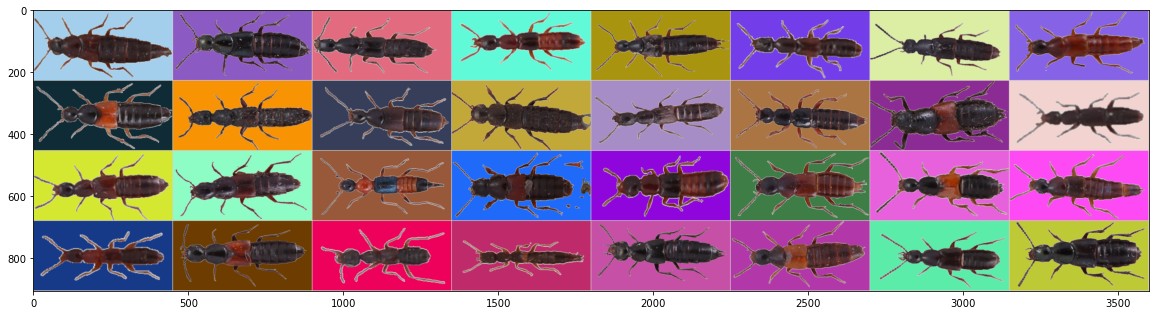

In [4]:
torch.cuda.empty_cache()

data_loaders, dataset_sizes = dataset_to_dataloaders(dataset_config)
iterable = iter(data_loaders['train'])
images, labels = next(iterable)
tensor_grid = make_grid(images, nrow=8)
image_grid = postprocess_image(tensor_to_image(tensor_grid))
show_img(image_grid, figsize=(20, 20))

# Define classification model

In [5]:
print('Loading {}'.format(model_config['model_architecture']))
model = download_model(model_config, dataset_config)

Loading resnet50


# Train and or load classification model

In [6]:
load = True

if load:
    metrics, model_config, dataset_config, training_config = load_model_weights_and_metrics(model, model_config)
    print(("test accuracy = %.2f %%" % training_config['train_info']['test_acc']))
else:
    metrics = fit(model, data_loaders, dataset_sizes,
                  model_config, training_config, dataset_config, plot_config, 
                  clear='notebook', plot=True, save_interval=1)
    acc = test_model(model, data_loaders['test'], training_config, model_config['device'])
_ = model.eval()

test accuracy = 88.50 %


# Expose layers

In [7]:
dreamnet = HookedModel(model)
_ = dreamnet.eval()
#dreamnet.show_modules()

# Lets dream!

## Choose image

You can see what a specific class's name is with the function below.

In [8]:
show_class_name(0, dataset_config)

class 0: ./data/beetles/images/achenium_humile


This one takes a class label and returns an image instead.

Class path/name: ./data/beetles/images/achenium_humile


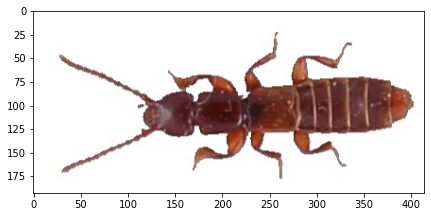

In [9]:
img = get_class_example_image(0, dataset_config)
show_img(img)

## Choose parameters and apply method

`out_info` is now a dictionary, and you can target modules in the model in a multitude of ways.

`{'fc': None}`      targets the entire `fc` layer

`{'fc': 1}`         targets class `1` in the `fc` layer

`{'fc': [0,1,2]}`   targets classes `0`,`1`,`2` in the `fc` layer


The same counts for 2d modules, such as `conv1`:

`{'conv1': (5,5)}`          targets `(5,5)` in `conv1`

`{'conv1': [(5,5), (2,2)]}`  targets `(5,5)` and `(2,2)` in `conv1`

In [10]:
import matplotlib.pyplot as plt
def softmax(vals, index):
    num = np.exp(vals[index])
    den = np.sum(np.exp(vals))
    return num / den

In [31]:
target = 21

In [33]:
params = {
    'input_img_path': 'data/beetles/images/achenium_humile/_0189_0.jpg',
    'target_dict': {'fc': target},
    'num_iters': 50,
    'levels': 3,
    'ratio':1.3,
    'lr': (0.5, 0.95),
    'lr_mode':            'ratio',
    #'smooth_const': 0,
    'noise': 'uniform',
    #'correlation' : 'gaussian',
    #'correlation_std' : 1,
    'target_shape': (200, 400),
    #'gauss_filter' : (7, 7, 5, 5),
    'show': True,
    'output_img_path': None,
    'video_path': None,
    'scale_type' : 'image_pyramid',

    'loss_type': 'mean',

    'penalty':            True,
    'penalty_loss_type':  'sum',
    'penalty_function':   'relu',
    'penalty_red':        'mean',
}
config.dream = get_new_config(params, DREAM_CONFIG)
output_images = dream_process(dreamnet, config)


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x00\xc8\x08\x02\x00\x00\x00Iw \xb5\x…

IndexError: index 125 is out of bounds for axis 1 with size 79

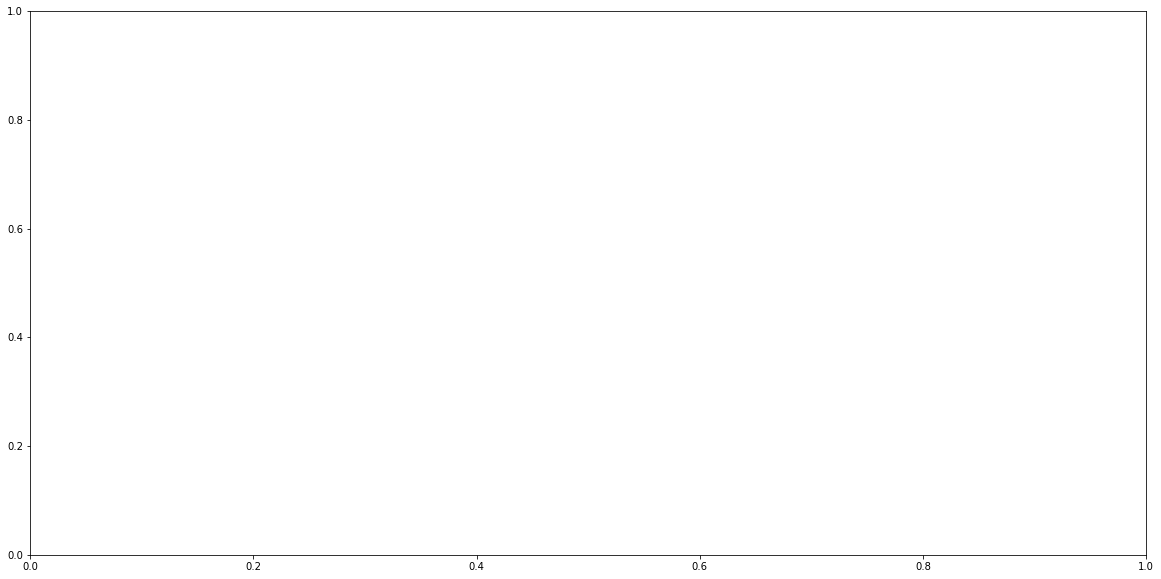

In [13]:
pred = np.argmax(output_images[1][0])
ranks = np.flip(np.argsort(output_images[1][0]))

fig, ax = plt.subplots(1,1,figsize=(20,10))
fig.patch.set_facecolor('white')

print(f'Target: {target} value: {output_images[1][0,target]} confidence: {softmax(output_images[1][0], target)}')
print(f'Prediction: {pred} value: {output_images[1][0,pred]} confidence: {softmax(output_images[1][0], pred)}')
print(f'5 best = {ranks[:5]}')
ax.plot(output_images[1][0])